# 12_A_CameraCalibration
In diesem Jupyter Notebook werden Visualisierungen aus den Kameraparametern einer gesamten Aufnahmezeitreihe erstellt, um Differenzen oder Unstimmigkeiten festzustellen.


### DJI Mini 3 Pro Kirsche - Visualisierung der Kameraparameter als Small Multiples (Parameterwerte - Zeit) 

mit und ohne Fehlerbalken (Standardabweichung des geschätzten Werts)

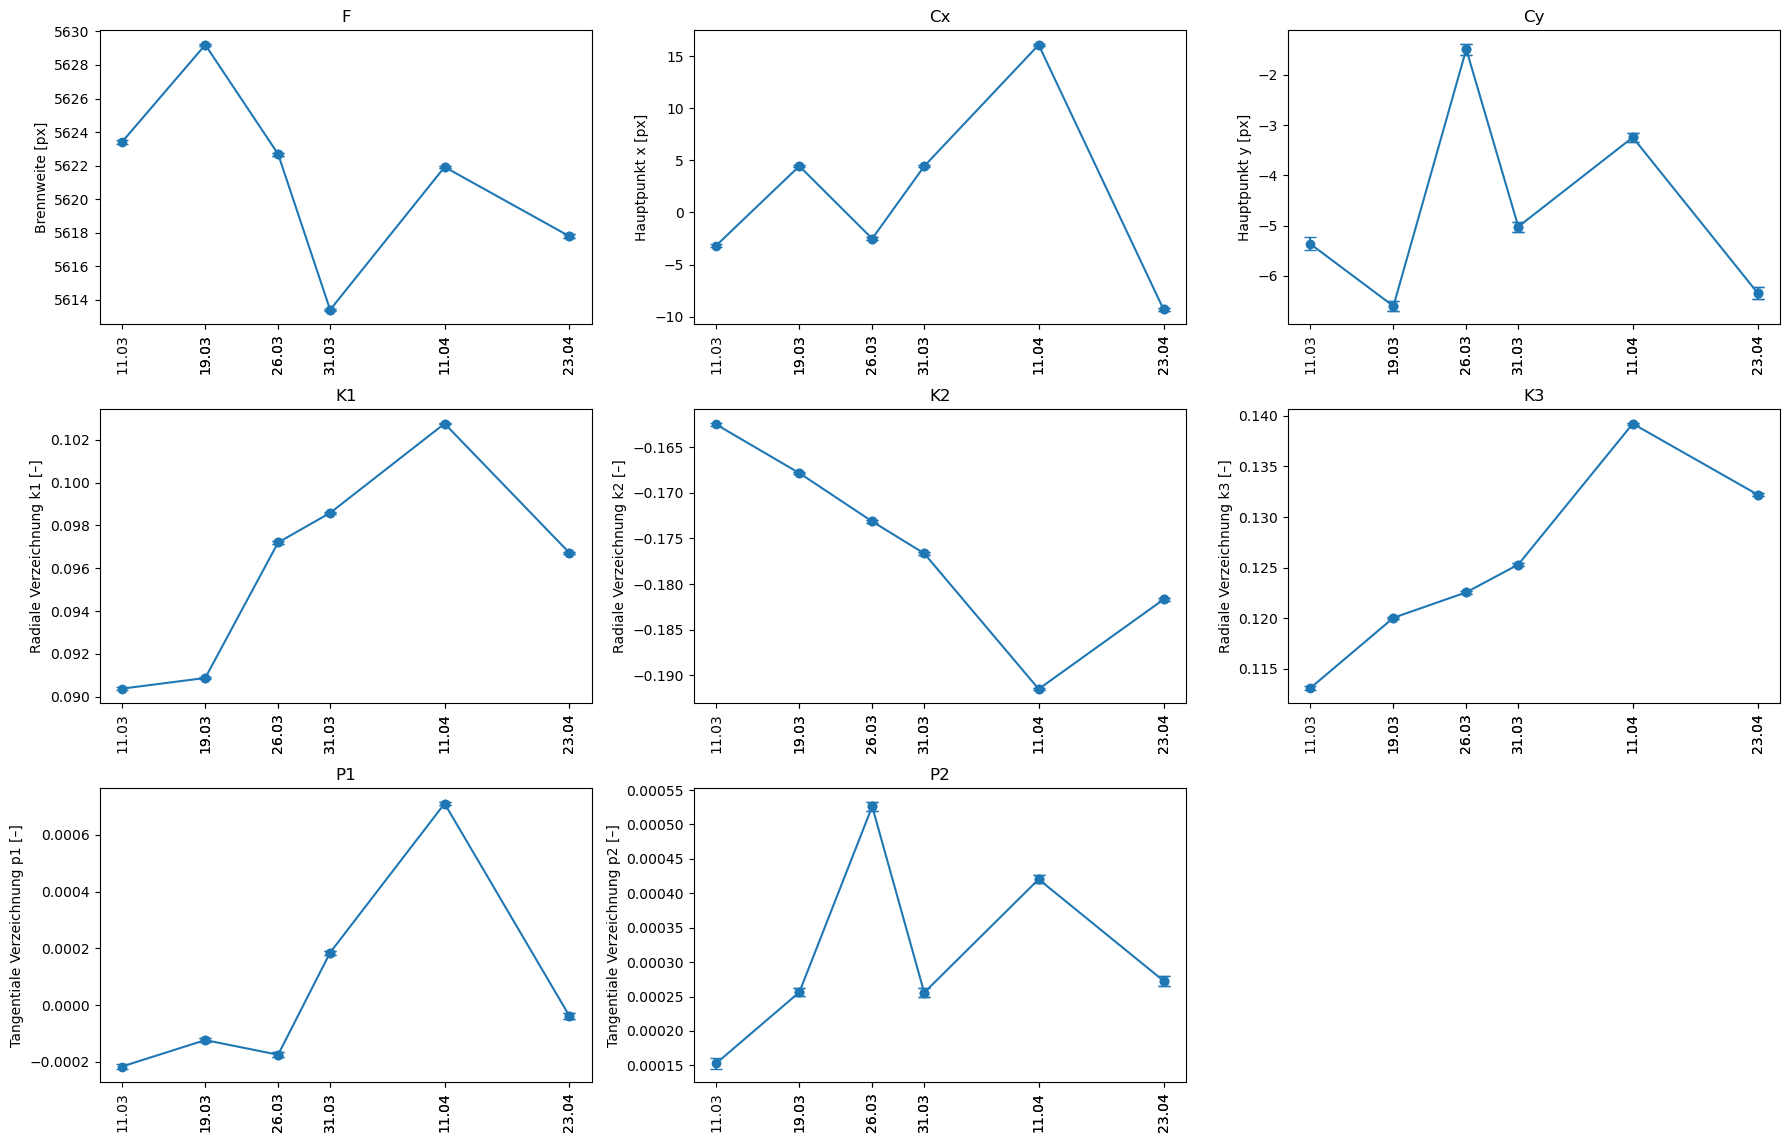

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# CSV laden
df = pd.read_csv("120_A_BaseData/Kameraparameter_DJIMini3Pro_Kirsche.csv")
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")
df = df.sort_values("Datum")

# Einheiten definieren
param_units = {
    "F": "Brennweite [px]",
    "Cx": "Hauptpunkt x [px]",
    "Cy": "Hauptpunkt y [px]",
    "K1": "Radiale Verzeichnung k1 [–]",
    "K2": "Radiale Verzeichnung k2 [–]",
    "K3": "Radiale Verzeichnung k3 [–]",
    "P1": "Tangentiale Verzeichnung p1 [–]",
    "P2": "Tangentiale Verzeichnung p2 [–]"
}

# Plot-Vorbereitung
unique_params = df["Kameraparameter"].unique()
n_params = len(unique_params)
ncols = 3
nrows = (n_params + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12), sharex=False)
axes = axes.flatten()

# Für jeden Parameter: Small Multiple mit Fehlerbalken und Achsenbeschriftung
for i, param in enumerate(unique_params):
    subset = df[df["Kameraparameter"] == param].sort_values("Datum")
    ax = axes[i]
    ax.errorbar(
        subset["Datum"], 
        subset["Value"], 
        yerr=subset["Error"], 
        fmt="-o", 
        capsize=4, 
        label=param
    )
    ax.set_title(param)
    ax.set_ylabel(param_units.get(param, "Wert"))
    ax.set_xticks(subset["Datum"])
    ax.set_xticklabels(subset["Datum"].dt.strftime("%d.%m"), rotation=90)

# Leere Achsen ausblenden
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




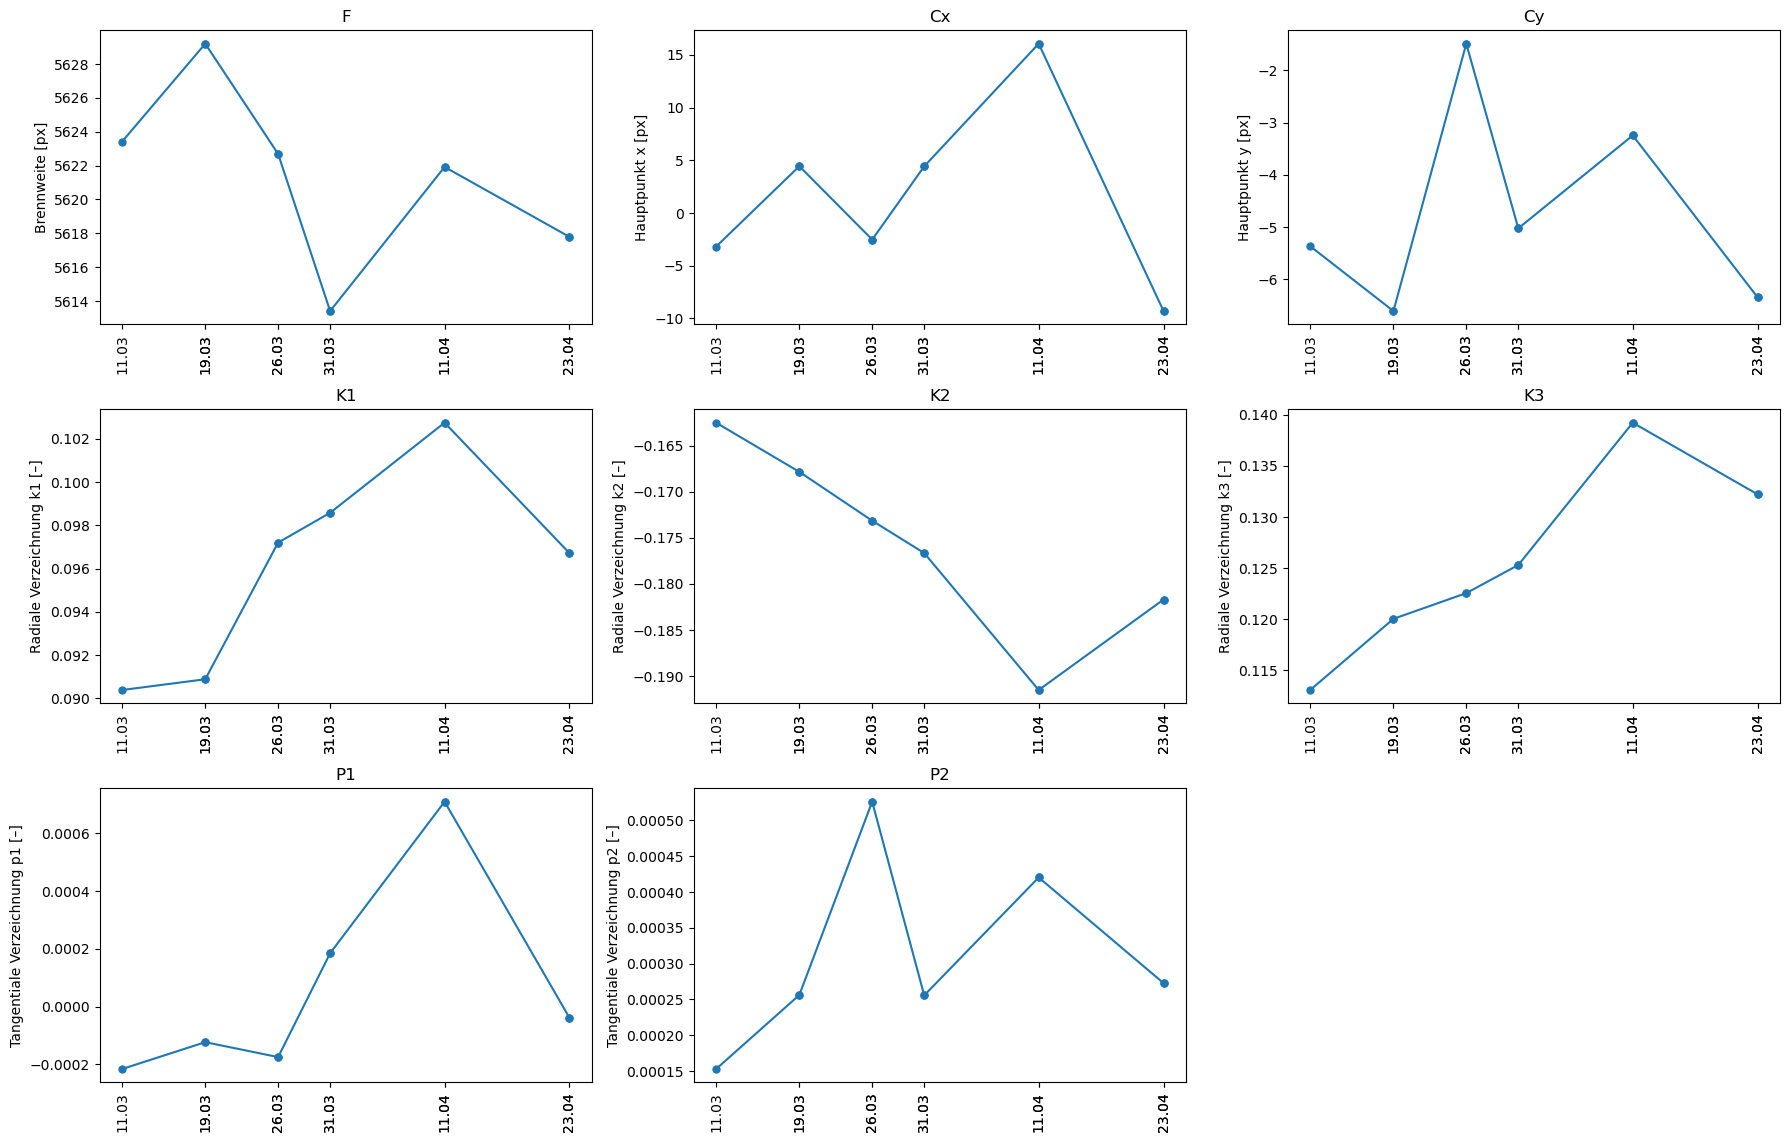

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# CSV laden
df = pd.read_csv("120_A_BaseData/Kameraparameter_DJIMini3Pro_Kirsche.csv")
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")
df = df.sort_values("Datum")

# Einheiten definieren
param_units = {
    "F": "Brennweite [px]",
    "Cx": "Hauptpunkt x [px]",
    "Cy": "Hauptpunkt y [px]",
    "K1": "Radiale Verzeichnung k1 [–]",
    "K2": "Radiale Verzeichnung k2 [–]",
    "K3": "Radiale Verzeichnung k3 [–]",
    "P1": "Tangentiale Verzeichnung p1 [–]",
    "P2": "Tangentiale Verzeichnung p2 [–]"
}

# Plot-Vorbereitung
unique_params = df["Kameraparameter"].unique()
n_params = len(unique_params)
ncols = 3
nrows = (n_params + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12), sharex=False)
axes = axes.flatten()

# Für jeden Parameter: Small Multiple mit Linien, ohne Fehlerbalken
for i, param in enumerate(unique_params):
    subset = df[df["Kameraparameter"] == param].sort_values("Datum")
    ax = axes[i]
    ax.plot(
        subset["Datum"],
        subset["Value"],
        marker='o',
        linestyle='-',
        markersize=5
    )
    ax.set_title(param)
    ax.set_ylabel(param_units.get(param, "Wert"))
    ax.set_xticks(subset["Datum"])
    ax.set_xticklabels(subset["Datum"].dt.strftime("%d.%m"), rotation=90)

# Leere Achsen ausblenden
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### DJI Mini 3 Pro Kirsche – Visualisierung der Kameraparameter als Heatmap (Abweichung vom Median)

Die Heatmap zeigt den **Z-Score** der Kameraparameter pro Aufnahmedatum. Damit wird ersichtlich, welche Parameter zu einem bestimmten Zeitpunkt **signifikant vom typischen Wert abweichen** – unabhängig vom Maßstab.

Definition des Z-Scores
$$
Z = \frac{x - \text{Median}}{\text{Standardabweichung}}
$$

Dabei gilt:
- \( Z = 0 \) → Wert entspricht exakt dem Median
- \( Z = 1 \) → Wert liegt eine Standardabweichung über dem Median
- \( Z = -2 \) → Wert liegt zwei Standardabweichungen unter dem Median

​


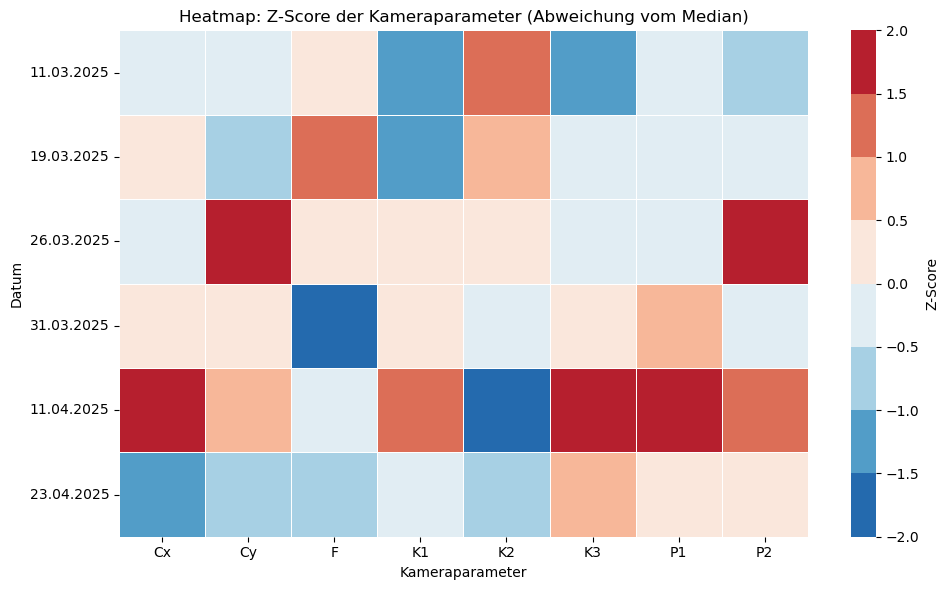

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CSV laden
df = pd.read_csv("120_A_BaseData/Kameraparameter_DJIMini3Pro_Kirsche.csv")
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")
df = df.sort_values("Datum")

# Pivot: Zeilen = Datum, Spalten = Parameter, Werte = Value
pivot_df = df.groupby(["Datum", "Kameraparameter"])["Value"].mean().unstack()

# Z-Score Berechnung (bezogen auf den Median)
zscore_df = (pivot_df - pivot_df.median()) / pivot_df.std()

# Achsen formatieren
zscore_df.index = zscore_df.index.strftime("%d.%m.%Y")

# Diskrete Farbstufen definieren
bounds = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
cmap = sns.color_palette("RdBu_r", n_colors=len(bounds) - 1)
norm = plt.matplotlib.colors.BoundaryNorm(bounds, len(cmap))

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    zscore_df,
    annot=False,
    cmap=cmap,
    norm=norm,
    linewidths=0.5,
    cbar_kws={"ticks": bounds, "label": "Z-Score"}
)

plt.title("Heatmap: Z-Score der Kameraparameter (Abweichung vom Median)")
plt.xlabel("Kameraparameter")
plt.ylabel("Datum")
plt.tight_layout()
plt.show()



### DJI Mini 3 Pro Kirsche - Visualisierung der Kameraparameter als Boxplot pro Kameraparameter

Die nachfolgende Visualisierung zeigt für jeden Kameraparameter einen **Boxplot** basierend auf den Kalibrierungsergebnissen mehrerer Zeitstände.

##### Bedeutung der Boxplots:

- Die Box stellt den Interquartilsabstand (IQR) dar:
  - Untere Kante = 1. Quartil (Q1)
  - Obere Kante = 3. Quartil (Q3)
  - Die Box umfasst somit die mittleren 50 % der Werte.
- Die mittlere Linie in der Box ist der Median.
- Die „Whisker“ reichen bis zu 1.5 × IQR über Q1/Q3 hinaus.
- Punkte außerhalb der Whisker gelten als statistische Ausreißer.

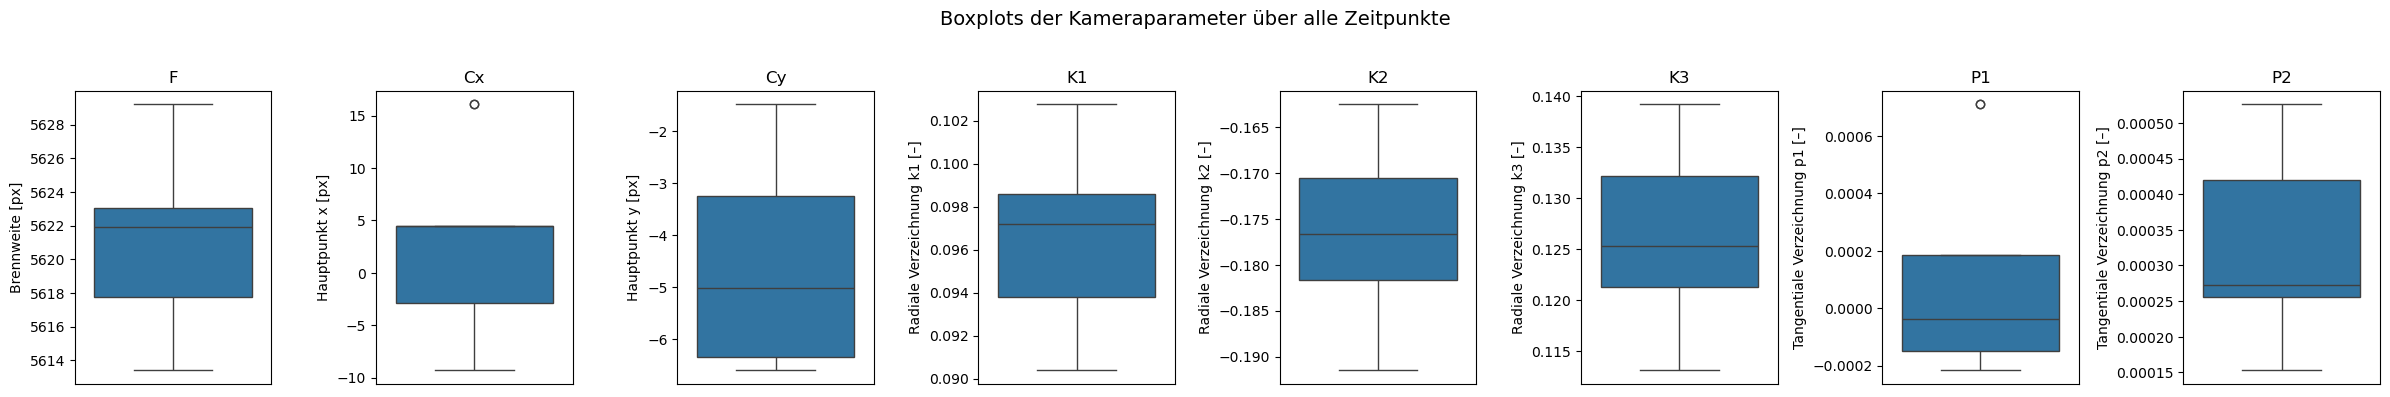

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV laden
df = pd.read_csv("120_A_BaseData/Kameraparameter_DJIMini3Pro_Kirsche.csv")
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")

# Einheiten für Y-Achsen
param_units = {
    "F": "Brennweite [px]",
    "Cx": "Hauptpunkt x [px]",
    "Cy": "Hauptpunkt y [px]",
    "K1": "Radiale Verzeichnung k1 [–]",
    "K2": "Radiale Verzeichnung k2 [–]",
    "K3": "Radiale Verzeichnung k3 [–]",
    "P1": "Tangentiale Verzeichnung p1 [–]",
    "P2": "Tangentiale Verzeichnung p2 [–]"
}

# Alle Kameraparameter extrahieren
unique_params = df["Kameraparameter"].unique()
n_params = len(unique_params)

# Plot-Vorbereitung: 8 Boxplots nebeneinander
fig, axes = plt.subplots(nrows=1, ncols=n_params, figsize=(3 * n_params, 4), sharey=False)

for i, param in enumerate(unique_params):
    subset = df[df["Kameraparameter"] == param]
    ax = axes[i]
    sns.boxplot(y=subset["Value"], ax=ax)
    ax.set_title(param)
    ax.set_ylabel(param_units.get(param, "Wert"))
    ax.set_xticks([])  # keine x-Achsen-Ticks

fig.suptitle("Boxplots der Kameraparameter über alle Zeitpunkte", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

